In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_curve, roc_auc_score, accuracy_score, classification_report
from sklearn.dummy import DummyClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, LabelEncoder

Why logistic regression?
    - Logistic regression is used for binary classification. This suits our project as we are classifying whether a tumour is malignant (M) or benign (B).

TODO: More work on overfitting / underfitting,
TODO: Cross validation?
https://www.kaggle.com/code/prashant111/logistic-regression-classifier-tutorial

# 1. Fitting the model

In [57]:
df = pd.read_csv('./Data Exploration/wdbc.csv')
labels = df['B/M']
df.drop(['ID', 'B/M'], axis=1, inplace=True)
features = df[['Radius', 'Texture', 'Compactness', 'Concavity', 'ConcavePoints', 'RadiusSE', 'ConcavitySE', 'ConcavePointsSE', 'RadiusWorst', 'TextureWorst', 'SmoothnessWorst', 'CompactnessWorst', 'ConcavityWorst', 'ConcavePointsWorst', 'SymmetryWorst']]

# 1.1 Standardization

In [58]:
# Standardize features
features[features.select_dtypes(['float64', 'int64']).columns.values] = ColumnTransformer([
        ('StandardScaler', StandardScaler(), features.columns.values)
    ]).fit_transform(df)

/tmp/ipykernel_19738/4033405741.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features[features.select_dtypes(['float64', 'int64']).columns.values] = ColumnTransformer([


# 1.2 Stratified train/test split

In [59]:
labels.value_counts()

B    357
M    212
Name: B/M, dtype: int64

In [60]:
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.25, random_state=0, stratify=labels)

# 1.3 Model Training
- Describe the training process, including the parameters involved and how they fit
- concerns about underfitting and/or overfitting
- and concerns about the convergence of the optimisation

In [61]:
model = LogisticRegression().fit(x_train, y_train)
y_pred = model.predict(x_test)  # Model classifications

In [62]:
pd.Series(y_pred).head()

0    M
1    B
2    B
3    B
4    B
dtype: object

# 2. Model Evaluation

# 2.1 Learning Curves
For determining whether our model is over-fitting the data.

As the model is trained on more samples, the training accuracy will increase. We can see that after training on ~110 and ~275 samples, the testing accuracy starts to reduce.

This shows that our model is over-fitting the data as the testing accuracy starts to reduce, as the model is prone to variance in the testing data. Training the model on ~250 samples would give us a model which generalises well.

**Conclusions**:
- Our model is over-fitting the data.
- We need more samples in our dataset.

['accuracy', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'average_precision', 'balanced_accuracy', 'completeness_score', 'explained_variance', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'fowlkes_mallows_score', 'homogeneity_score', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted', 'matthews_corrcoef', 'max_error', 'mutual_info_score', 'neg_brier_score', 'neg_log_loss', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_gamma_deviance', 'neg_mean_poisson_deviance', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_median_absolute_error', 'neg_negative_likelihood_ratio', 'neg_root_mean_squared_error', 'normalized_mutual_info_score', 'positive_likelihood_ratio', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'r2', 'rand_score', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'roc_auc', 'roc_auc_ovo', 'roc_auc_ovo_weight

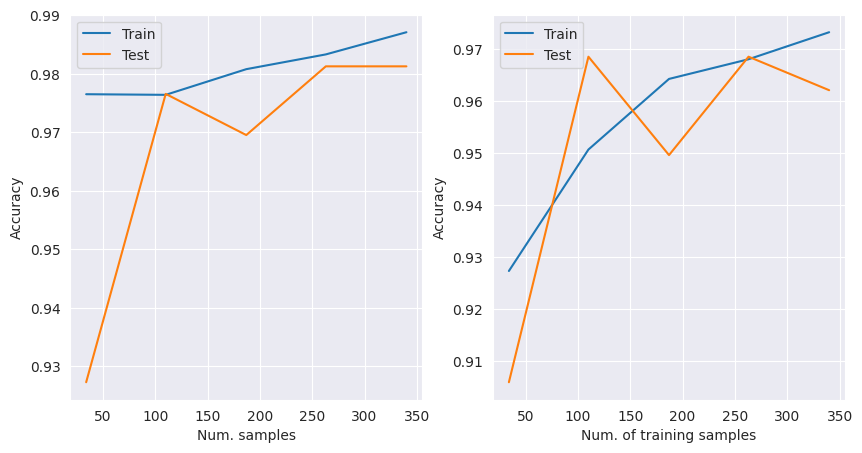

In [79]:
train_sizes_abs_accuracy, train_accuracy, test_accuracy = learning_curve(estimator=model, X=x_train, y=y_train, scoring='accuracy', cv=5)
# todo: recall (or precision? or f1), should I keep?
train_sizes_abs_error, train_error, test_error = learning_curve(estimator=model, X=x_train, y=LabelEncoder().fit_transform(y_train), scoring='recall', cv=5)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
# Array of tuples (train_size, train_score)
train_avg_accuracy, test_avg_accuracy, train_avg_error, test_avg_error = [], [], [], []

for i in range(len(train_sizes_abs_accuracy)):
    train_avg_accuracy.append(np.average(train_accuracy[i]))
    test_avg_accuracy.append(np.average(test_accuracy[i]))

for i in range(len(train_sizes_abs_error)):
    train_avg_error.append(np.average(train_error[i]))
    test_avg_error.append(np.average(test_error[i]))

# Accuracy learning curve
ax[0].plot(train_sizes_abs_accuracy, train_avg_accuracy)
ax[0].plot(train_sizes_abs_accuracy, test_avg_accuracy)
ax[0].legend(['Train', 'Test'])
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Num. samples')

# Error learning curve
ax[1].plot(train_sizes_abs_error, train_avg_error)
ax[1].plot(train_sizes_abs_error, test_avg_error)
ax[1].legend(['Train', 'Test'])
ax[1].set_xlabel('Num. of training samples')
ax[1].set_ylabel('Recall')
plt.show()

# 2.2 Classification Reports

Classification algorithms have the following types of classifications:
- True positives (TP)
- False positives (FP)
- True negatives (TN)
- False negatives (FN)

Since our model classifies cancerous cells, the cost of a False Negative is much greater than the rest. Classifying a cell as Benign when it is Malignant can have terrible consequences on the patient.

In [64]:
c = confusion_matrix(y_test, y_pred)
print(f'True negatives: {c[0][0]}')
print(f'False negatives: {c[1][0]}')
print(f'True positives: {c[1][1]}')
print(f'False positives: {c[0][1]}')

True negatives: 89
False negatives: 2
True positives: 51
False positives: 1


In [65]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           B       0.98      0.99      0.98        90
           M       0.98      0.96      0.97        53

    accuracy                           0.98       143
   macro avg       0.98      0.98      0.98       143
weighted avg       0.98      0.98      0.98       143



# 2.3 Evaluation Metrics

In [66]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print(f'Recall: {recall_score(y_test, y_pred, pos_label="M")}')
print(f'Precision: {precision_score(y_test, y_pred, pos_label="M", zero_division=0)}')

Accuracy: 0.9790209790209791
Recall: 0.9622641509433962
Precision: 0.9807692307692307


# 2.4 Dummy Model

In [67]:
dm = DummyClassifier()
dm.fit(x_train, y_train)
dummy_score = dm.score(x_test, y_test)
print(f'{"Our model beats the dummy model" if accuracy > dummy_score else "Our model does not beat the dummy model."}')

Our model beats the dummy model


# 3. Hyperparameter Tuning

# 3.1 ROC Curve
Tuning the threshold p-value and seeing how this affects our classifications.

ROC Curves shows us the True Positive rate (TP / (TP + FN)) against the False Positive Rate (FP / (FP + TN)) with different thresholds.

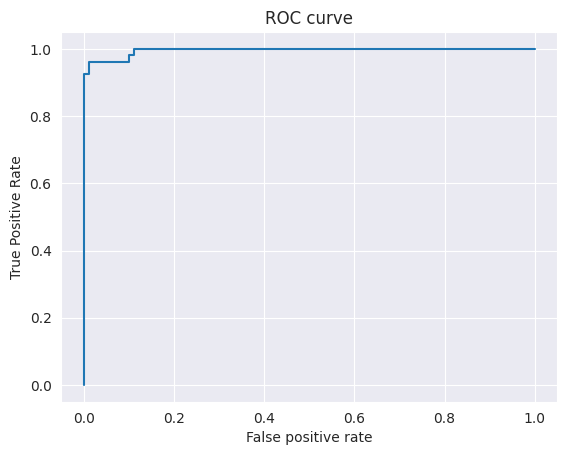

In [68]:
# First col is the p that a sample is class B, second col is p that sample is class M
y_pred_prob = model.predict_proba(x_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[:, 1], pos_label = 'M')

plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('False positive rate')
plt.ylabel('True Positive Rate')
plt.show()

We want to find the threshold which finds the balance between the TPR and the FPR.

Since our model is being used to classify tumorous cells, it is important to maximise the TPR.

In [69]:
for idx, metric in enumerate(list(zip(tpr, fpr, thresholds))[1::]):
    tpr_, fpr_, threshold =  metric[0], metric[1], metric[2]
    print(f'''
    TPR: {tpr_}
    FPR: {fpr_}
    threshold: {threshold}
    threshold_idx: {idx + 1}
    ''')


    TPR: 0.018867924528301886
    FPR: 0.0
    threshold: 0.999999999790911
    threshold_idx: 1
    

    TPR: 0.9245283018867925
    FPR: 0.0
    threshold: 0.8315919374366341
    threshold_idx: 2
    

    TPR: 0.9245283018867925
    FPR: 0.011111111111111112
    threshold: 0.7383992813613822
    threshold_idx: 3
    

    TPR: 0.9622641509433962
    FPR: 0.011111111111111112
    threshold: 0.5621707856777968
    threshold_idx: 4
    

    TPR: 0.9622641509433962
    FPR: 0.1
    threshold: 0.23993574329130612
    threshold_idx: 5
    

    TPR: 0.9811320754716981
    FPR: 0.1
    threshold: 0.19675698073704873
    threshold_idx: 6
    

    TPR: 0.9811320754716981
    FPR: 0.1111111111111111
    threshold: 0.15953031511436627
    threshold_idx: 7
    

    TPR: 1.0
    FPR: 0.1111111111111111
    threshold: 0.14520388865008646
    threshold_idx: 8
    

    TPR: 1.0
    FPR: 1.0
    threshold: 2.579095260685954e-06
    threshold_idx: 9
    


# 3.2 Threshold tuning
**Using ROC to change our threshold to reduce False Negative classifications.**

- For our application, the cost of a False Negative is greater than other classifications.

We want to:
- Minimize false negatives.
- Increase true positives.

Thus we must find a balance between the True Positive Rate (TPR) and False Positive Rate (FPR).

I think a reasonable balance is given by threshold (with idx 4)

In [70]:
threshold = thresholds[4]

# 3.3 AUC
AUC is the area under the ROC graph. **We can use AUC to compare two classification models**.

In [71]:
roc_auc_score(y_true=y_test, y_score=y_pred_prob[:, 1])

0.9955974842767294

# Conclusions
- Make conclusions on AUC between models

# 3.4 Testing model with new threshold
The new threshold has changed the TPR and FPR rates. How does this affect our models performance?

- Create precision-recall curve?

In [72]:
new_predictions = []

for p in y_pred_prob[:, 1]:
    # Probability of M exceeds threshold, classify as M
    if p >= threshold:
        new_predictions.append('M')

    else:
        new_predictions.append('B')

new_predictions = pd.Series(new_predictions)

In [73]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           B       0.98      0.99      0.98        90
           M       0.98      0.96      0.97        53

    accuracy                           0.98       143
   macro avg       0.98      0.98      0.98       143
weighted avg       0.98      0.98      0.98       143



In [74]:
print(classification_report(y_test, new_predictions))

              precision    recall  f1-score   support

           B       0.98      0.99      0.98        90
           M       0.98      0.96      0.97        53

    accuracy                           0.98       143
   macro avg       0.98      0.98      0.98       143
weighted avg       0.98      0.98      0.98       143

